In [1]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

2024-03-22 23:08:11.908164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Download the training data from MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
# Uncomment to reduce the size of the training set
# train_images = train_images[:10000]
# train_labels = train_labels[:10000]
# train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

In [4]:
# Let's see the shape of an image:
train_images[327].shape

(28, 28)

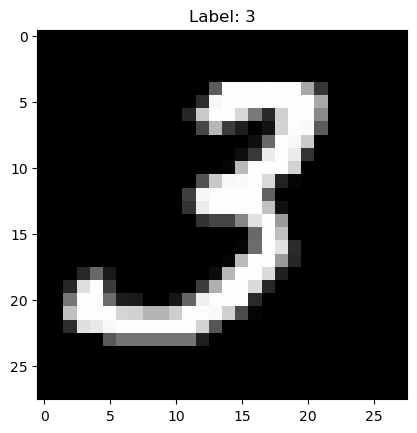

In [5]:
# Now let's plot the 327th sample to see what the raw image look like
plt.plot()
plt.title(f"Label: {train_labels[327]}")
plt.imshow((train_images[327]), cmap=plt.get_cmap('gray'))
plt.show()

In [6]:
# Let's verify it matches the 327th label!
train_labels[327]

3

In [7]:
# Pixel values are black & white, and between 0 and 255
train_images.min(), train_images.max()

(0, 255)

In [8]:
# Let's normalize their values to be between 0 and 1
train_images, test_images = train_images / 255, test_images / 255
# Checking normalization
train_images.min(), train_images.max()

(0.0, 1.0)

In [9]:
train_n = train_images.shape[0]
test_n = test_images.shape[0]
train_n, test_n

(60000, 10000)

In [10]:
# Now we reshape the images sets (add a 4th dimension) to be compatible with a CNN model
train_images = train_images.reshape((train_n, 28, 28, 1))
test_images = test_images.reshape((test_n, 28, 28, 1))
train_images.shape, test_images.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [11]:
# Let's find unique values in the labels
import numpy as np
nb_values = len(np.unique(train_labels))
nb_values

10

In [12]:
# One-hot encoding of the labels (5 -> [0, 0, 0, 0, 0, 1, ...])
# cf. https://en.wikipedia.org/wiki/One-hot
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [13]:
# Let's verify that labels are now a 10-list of values
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [14]:
# Nice, a 60000 long list of 10-value lists
train_labels.shape

(60000, 10)

In [39]:
# The MNIST dataset is very easy to model (best perf is ~99.7%!) so you shouldn't need
# to have a very complicated neural net for this one: at the minimum, you need:
#   - a Conv2D layer, ideally using ReLU
#   - a Flatten() layer
#   - a final Dense(...) layer
def define_conv_model(conv_size=32):
    model = models.Sequential()

    model.add(layers.Conv2D(conv_size, (3, 3), input_shape=(28, 28, 1), activation='relu'))
    # optimizes perf for whatever reason...
    model.add(layers.BatchNormalization())
    # also optimizes perf for whatever reason...
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    # We would normally have a first dense layer here, but it's not needed for something as simple as the MNIST
    # model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(nb_values, activation='softmax'))

    return model

In [40]:
# Notes:
#   - the 'sparse_categorical_crossentropy' loss is only for labels using integers
#   - we specify the optimizer instead of 'adam' to be able to change the learning rate
#   - no need to return anything, the model is modified "in-place" 
def compile_model(model, learning_rate=0.003):
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
# We parameterize the training so that parameters can be logged in MLFlow
def train_model(model, train_images, train_labels, epochs=3, batch_size=64, validation_split=0.2):
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

In [42]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.set_tracking_uri("http://192.168.0.153:5000")
mlflow.set_experiment("Brief 13 - 1. MNIST")

<Experiment: artifact_location='mlflow-artifacts:/540838423398902132', creation_time=1709463356443, experiment_id='540838423398902132', last_update_time=1709463356443, lifecycle_stage='active', name='Brief 13 - 1. MNIST', tags={}>

In [43]:
import time

with mlflow.start_run():
    conv_size = 16
    learning_rate = 0.004
    epochs = 3
    batch_size = 64

    mlflow.log_param("conv_size", conv_size)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)

    mlflow.set_tag("Divers", "Yolo")
    
    model = define_conv_model(conv_size)
    compile_model(model, learning_rate)
    
    # We time only time the training part
    start_t = time.time()    
    train_model(model, train_images, train_labels, epochs, batch_size)
    end_t = time.time()

    # Evaluate the model on the test set
    loss, acc = model.evaluate(test_images, test_labels)
    print(f'Loss: {loss}, accuracy: {acc}')
    
    mlflow.log_metric("loss", loss)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("training_duration", end_t - start_t)  

    mlflow.log_artifacts("model_MNIST", artifact_path="models")

Epoch 1/3
750/750 [==============================] - 12s 16ms/step - loss: 0.1832 - accuracy: 0.9448 - val_loss: 0.0892 - val_accuracy: 0.9741
Epoch 2/3
750/750 [==============================] - 11s 15ms/step - loss: 0.0875 - accuracy: 0.9727 - val_loss: 0.1106 - val_accuracy: 0.9692
Epoch 3/3
313/313 [==============================] - 1s 4ms/step - loss: 0.0663 - accuracy: 0.9793
Loss: 0.06626111268997192, accuracy: 0.9793000221252441


In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 batch_normalization_3 (Bat  (None, 26, 26, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 13, 13, 16)        0         
                                                                 
 flatten_2 (Flatten)         (None, 2704)              0         
                                                                 
 dense_3 (Dense)             (None, 10)               

In [53]:
# Save model for part III
model.save('model_mnist.keras')